Notebook del modelo de árbol de decisión del dataframe de las peleas ponderadas

- **Tarea del backlog:** https://github.com/UCM-GIDIA-PD1/c2425-R4/issues/31
- **Propósito del código:** Árbol de clasificación para el dataframe de peleas ponderadas (P2).
- **Autor(es):** Carlos Vallejo.  
- **Descripción y uso:** Además de intentar sacar el mejor modelo posible, tenemos como objetivo ver que variables tienen peso en el modelo.

In [35]:
#NO BORRAR ESTA CELDA!!!!!!!!!!!!!!!!

#Marca con un * al final las que ya estén solucionadas

#Solucionar:
#Explica cada modelo un poco: que hace, porque lo usas *
#Nueva correción:
#Aunque me digiste que el modelo siempre te elige profundidad 3, haz el grid search con mas de tres para que el maestro lo vea. A no ser que expliques bien porque lo haces con tres, si tu objetivo
#es que se vea bien el árbol *
#Te falta explicar mucho en general de todo y poner el índice. Haz algo paracido a lo que ha hecho telmo. Su notebook está en P1 y es arbol_decision.ipynb *

### Índice del notebook

* [Descripcion general del notebook](#descripcion-general-del-notebook)  
* [Carga y preprocesamiento de los datos](#carga-y-preprocesamiento-de-los-datos)
* [Transformaciones](#transformaciones)
* [Seleccion de variables](#seleccion-de-variables)
* [Grid Search](#grid-search)
* [Random Search](#random-search)

In [36]:
import os
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,log_loss, f1_score, roc_auc_score, precision_score, recall_score, make_scorer
from sklearn import tree  
from sklearn.tree import plot_tree

import seaborn as sns
import matplotlib.pyplot as plt

### Descripcion general del notebook

En este notebook se harán dos árboles de decisión para el dataset de peleas ponderadas, uno ajustando los hiperparámetros con Grid Search y otro con Random Search. El objetivo principal del notebook es identificar las variables más significativas del conjunto de datos, en lugar de centrarnos exclusivamente en la optimización de los modelos. Dado que hay desbalance de clases en el conjunto de datos, usaremos f1-score como métrica principal para evaluar los modelos.

### Carga y preprocesamiento de los datos

Primero de todo, cargamos los datos de entrenamiento y prueba, almacenados en archivos separados con formato Parquet. 

In [37]:
ruta_train =  os.path.join("..","..","..", "data", "P2","train.parquet")
train = pd.read_parquet(ruta_train)

ruta_test =  os.path.join("..","..","..", "data", "P2","test.parquet")
test = pd.read_parquet(ruta_test)

test.head()

,DATE,Peleador_A,Peleador_B,WINNER,KD_A,KD_B,SIG_STR_A,SIG_STR_B,TD_PORC_A,TD_PORC_B,...,Puntos_A,Puntos_B,Peleas_A,Peleas_B,KD_DIFF,SIG_STR_DIFF,TD_DIFF,SUB_ATT_DIFF,REV_DIFF,CTRL_DIFF
0,2023-02-04,Derrick Lewis,Serghei Spivac,True,0.40,0.00,0.5864,0.3636,0.1200,0.4500,...,189.612060,8.036330e+01,25,9,0.40,0.2228,-0.307248,-0.36,0.0,-136.44
1,2023-02-04,Dooho Choi,Kyle Nelson,True,0.36,0.00,0.4824,0.6552,0.0800,0.0000,...,0.000000,0.000000e+00,6,5,0.36,-0.1728,0.133333,0.00,0.0,-61.20
2,2023-02-04,Marcin Tybura,Blagoy Ivanov,False,0.00,0.00,0.4276,0.5056,0.2000,0.2792,...,139.896213,2.207734e-07,16,6,0.00,-0.0780,-0.188071,-0.40,0.0,-56.72
3,2023-02-11,Tyson Pedro,Modestas Bukauskas,True,0.60,0.00,0.6544,0.4112,0.0000,0.0000,...,24.394312,0.000000e+00,8,4,0.60,0.2432,0.000000,0.40,0.0,16.88
4,2023-02-11,Islam Makhachev,Alexander Volkanovski,False,0.36,0.24,0.6300,0.5844,0.7576,0.1200,...,322.872251,5.342818e+02,13,12,0.12,0.0456,0.130692,1.16,-0.8,5.28


### Transformaciones

No es necesario realizar transformaciones en los datos antes de entrenar un árbol de decisión, ya que estos modelos pueden manejar datos sin necesidad de normalización o estandarización. En caso de existir variables categóricas si se deberían codificar, pero en nuestro caso no hay (sin contar fechas y peleadores).

### Seleccion de variables

Tampoco es estrictamente necesario hacer una selección de variables antes de entrenar un árbol de decisión, ya que este modelo selecciona automáticamente las características más relevantes. Únicamente vamos a eliminar las variables categóricas en 'X_train' y 'X_test' además de la variable respuesta.

In [38]:
columnasQuitar = ["DATE","Peleador_A","Peleador_B", "WINNER"] #categóricas y variable respuesta

X_train = train.drop(columns=columnasQuitar)
y_train = train['WINNER']
X_test = test.drop(columns=columnasQuitar)
y_test = test['WINNER']

### Ajuste de hiperparametros

Para ajustar los parámetros hemos utilizado dos estrategias, GridSearchCV y RandomizedSearchCV.

#### Grid Search

In [39]:
def train_decision_tree_grid(X_train, y_train, X_test, y_test):
    from sklearn.tree import plot_tree
    # Calcular pesos de clase para manejar desbalance de datos
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
    tscv = TimeSeriesSplit(n_splits=5)


    # Definir modelo base
    dt = DecisionTreeClassifier(random_state=42)

    # Cuadrícula de hiperparámetros
    param_grid = {
        'criterion': ['gini', 'entropy'],  # Función para medir la calidad de la división
        'max_depth': [3, 5, 10],  # Profundidad máxima del árbol
        'min_samples_split': [2, 5, 10],  # Mínimo de muestras para dividir un nodo
        'min_samples_leaf': [1, 2, 4],  # Mínimo de muestras en una hoja
        'min_weight_fraction_leaf': [0.10, 0.12, 0.14],
        'splitter': ['best','random'],
        'class_weight': [None, class_weight_dict],  # Ajuste de pesos por clase
        'max_features': [None, 'sqrt', 'log2']
    }
    

    f1_scorer = make_scorer(f1_score, average='macro')

    # Búsqueda de hiperparámetros con validación cruzada
    grid_search = GridSearchCV(
        estimator=dt,
        param_grid=param_grid,
        scoring= f1_scorer,
        cv=tscv,
        n_jobs=-1,
        verbose=2
    )

    # Entrenar el modelo
    grid_search.fit(X_train, y_train)

    # Imprimir mejores parámetros
    print("Mejores parámetros:", grid_search.best_params_)

    # Evaluar el mejor modelo en el conjunto de validación
    y_pred = grid_search.best_estimator_.predict(X_test)
    print("Reporte de clasificación:")
    print(classification_report(y_test, y_pred))

    # Visualización del árbol
    plt.figure(figsize=(15, 8))
    plot_tree(grid_search.best_estimator_, filled=True, feature_names=X_train.columns, class_names=["False", "True"])
    plt.show()

    return grid_search.best_estimator_

Una vez hecha la función que ajusta los hiperparámetros con Grid Search, hacemos un modelo para ver tanto las métricas como la importancia de las variables.

Fitting 5 folds for each of 1944 candidates, totalling 9720 fits
Mejores parámetros: {'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.1, 'splitter': 'best'}
Reporte de clasificación:
              precision    recall  f1-score   support

       False       0.60      0.75      0.66       327
        True       0.55      0.38      0.45       267

    accuracy                           0.58       594
   macro avg       0.58      0.57      0.56       594
weighted avg       0.58      0.58      0.57       594



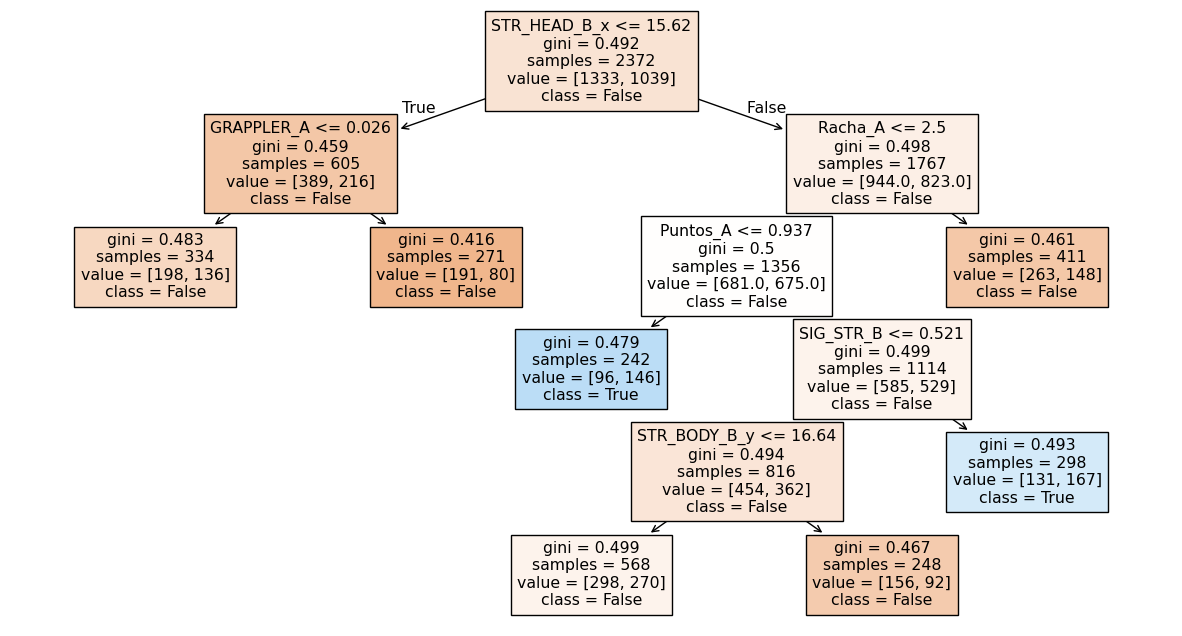

In [40]:
tree = train_decision_tree_grid(X_train, y_train, X_test, y_test)

Variables con importancia en el modelo: SIG_STR_B, Importancia: 0.13960
Variables con importancia en el modelo: STR_HEAD_B_x, Importancia: 0.24992
Variables con importancia en el modelo: STR_BODY_B_y, Importancia: 0.08822
Variables con importancia en el modelo: GRAPPLER_A, Importancia: 0.08799
Variables con importancia en el modelo: Racha_A, Importancia: 0.28044
Variables con importancia en el modelo: Puntos_A, Importancia: 0.15382


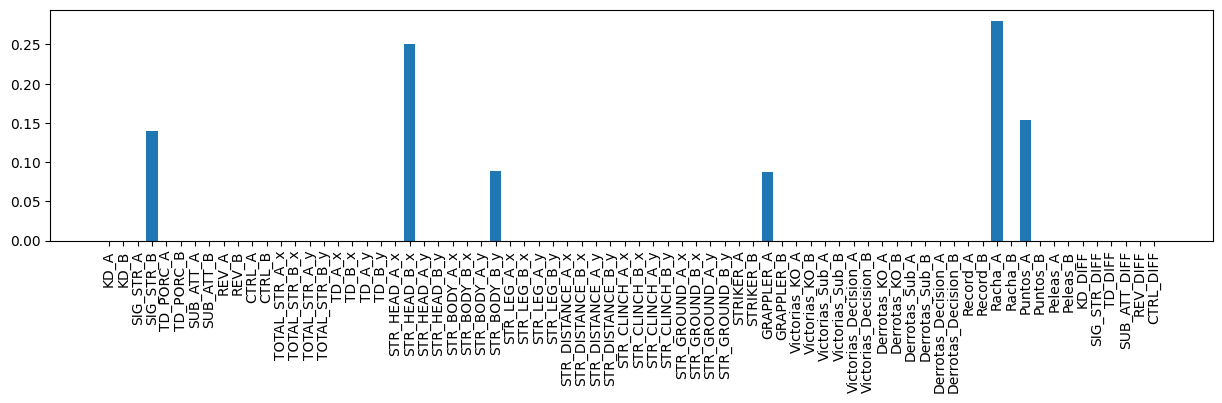

In [41]:
importance = tree.feature_importances_
feature_names=X_train.columns
for i,v in enumerate(importance):
	if v > 0:
	    print('Variables con importancia en el modelo: %s, Importancia: %.5f' % (feature_names[i],v))

plt.figure(figsize=(15, 3))
plt.bar([x for x in range(len(importance))], importance, tick_label = feature_names)
plt.xticks(rotation = 90)
plt.show()

In [42]:
#Observamos todos los valores de las métricas.
print("-- Métricas del modelo con hiperparámetros ajustados --")
y_test_pred = tree.predict(X_test)
y_test_prob = tree.predict_proba(X_test)[:,1]
print("Accuracy:", accuracy_score(y_test, y_test_pred))
f1_test = f1_score(y_test, y_test_pred)
roc_auc_test = roc_auc_score(y_test, y_test_prob)
precision_test = precision_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)
log_loss_test = log_loss(y_test,y_test_prob)
print(f"F1-Score: {f1_test:.4f}")
print(f"AUC-ROC: {roc_auc_test:.4f}")
print(f"Precisión: {precision_test:.4f}")
print(f"Sensibilidad: {recall_test:.4f}")
print(f"Log-loss: {log_loss_test}")
print(confusion_matrix(y_test, y_test_pred))


-- Métricas del modelo con hiperparámetros ajustados --
Accuracy: 0.5841750841750841
F1-Score: 0.4523
AUC-ROC: 0.5852
Precisión: 0.5543
Sensibilidad: 0.3820
Log-loss: 0.6782888030644489
[[245  82]
 [165 102]]


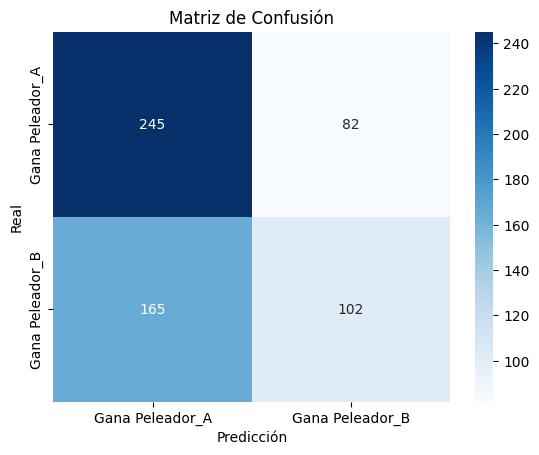

In [43]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_test_pred)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Gana Peleador_A', 'Gana Peleador_B'], yticklabels=['Gana Peleador_A', 'Gana Peleador_B'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

Como vemos, con Grid Search el modelo no parece ser muy bueno ya que ronda el 0.58 en métricas como el accuracy. No obstante, como previamente hemos dicho, este no era el objetivo del modelo. Además, es interesante ver que cuando se debería predecir la victoria del peleador A, hay más predicciones a favor del peleador B'. Esto obviamente no es lo que se desea ver en una matriz de confusión, pero no es tan malo como aparenta. Como bien sabemos, el peleador A es el que más ranking tiene de los dos peleadores, lo que normalmente se suele traducir a que es el favorito (no siempre es así), por lo que acertar la victoria del no favorito es bastante difícil y tiene mucho valor. En este caso, de 267 peleas acierta en 102 (38% acierto), una estadística que parece pobre pero no es para nada así. Vamos a probar con Random Search.

#### Random Search

In [44]:
def train_decision_tree_random(X_train, y_train, X_test, y_test):
    from sklearn.tree import plot_tree
    # Calcular pesos de clase para manejar desbalance de datos
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}
    tscv = TimeSeriesSplit(n_splits=5)

    # Definir modelo base
    dt2 = DecisionTreeClassifier(random_state=42, class_weight=class_weight_dict)

    # Distribución de hiperparámetros para búsqueda aleatoria
    param_dist = {
    "criterion": ["gini", "entropy"],
    "max_depth": [3, 5, 10],
    "min_samples_split": [int(x) for x in np.arange(2, 20, 2)],
    "min_samples_leaf": [int(x) for x in np.arange(1, 20, 2)],
    'min_weight_fraction_leaf': [0.10, 0.12, 0.14],
    'splitter': ['best'],
    "max_features": ["sqrt", "log2", None],
    'class_weight': [None, class_weight_dict],  # Ajuste de pesos por clase
    'min_impurity_decrease': [0,0.0001,0.001]
    }

    #  ['ccp_alpha','max_leaf_nodes',
    #  'min_weight_fraction_leaf', 'monotonic_cst', 'random_state']  otros posibles parámetros

    # Definir la métrica de optimización como el F1-score macro
    f1_scorer = make_scorer(f1_score, average='macro')

    # Búsqueda con validación cruzada
    random_search = RandomizedSearchCV(
        estimator=dt2,
        param_distributions=param_dist,
        scoring=f1_scorer,
        n_iter=50,
        cv=tscv,
        n_jobs=-1,
        verbose=2,
        random_state=42
    )


    # Entrenar el modelo
    random_search.fit(X_train, y_train)

    # Imprimir mejores parámetros
    print("Mejores parámetros:", random_search.best_params_)

    # Evaluar el mejor modelo en el conjunto de validación
    y_pred = random_search.best_estimator_.predict(X_test)
    print("Reporte de clasificación:")
    print(classification_report(y_test, y_pred))

    plt.figure(figsize=(15, 8))
    plot_tree(random_search.best_estimator_, filled=True, feature_names=X_train.columns, class_names=["False", "True"])
    plt.show()

    return random_search.best_estimator_

Como hemos hecho con Grid Search, vamos a entrenar un modelo.

-- Entrenamiento usando ajuste de hiperparámetros con RandomizedSeachCV --
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Mejores parámetros: {'splitter': 'best', 'min_weight_fraction_leaf': 0.1, 'min_samples_split': 4, 'min_samples_leaf': 7, 'min_impurity_decrease': 0.001, 'max_features': None, 'max_depth': 5, 'criterion': 'entropy', 'class_weight': None}
Reporte de clasificación:
              precision    recall  f1-score   support

       False       0.60      0.75      0.66       327
        True       0.55      0.38      0.45       267

    accuracy                           0.58       594
   macro avg       0.58      0.57      0.56       594
weighted avg       0.58      0.58      0.57       594



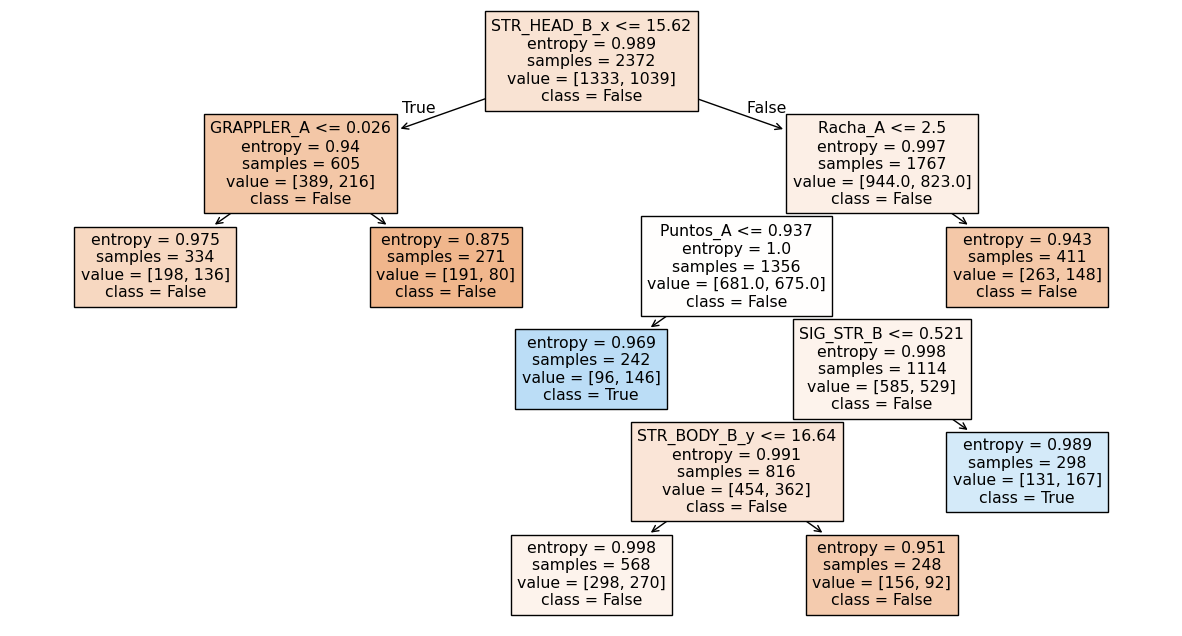

In [45]:
print("-- Entrenamiento usando ajuste de hiperparámetros con RandomizedSeachCV --")
tree2 = train_decision_tree_random(X_train,y_train,X_test,y_test)

Variables con importancia en el modelo: SIG_STR_B, Importancia: 0.13669
Variables con importancia en el modelo: STR_HEAD_B_x, Importancia: 0.25105
Variables con importancia en el modelo: STR_BODY_B_y, Importancia: 0.08806
Variables con importancia en el modelo: GRAPPLER_A, Importancia: 0.09434
Variables con importancia en el modelo: Racha_A, Importancia: 0.27876
Variables con importancia en el modelo: Puntos_A, Importancia: 0.15109


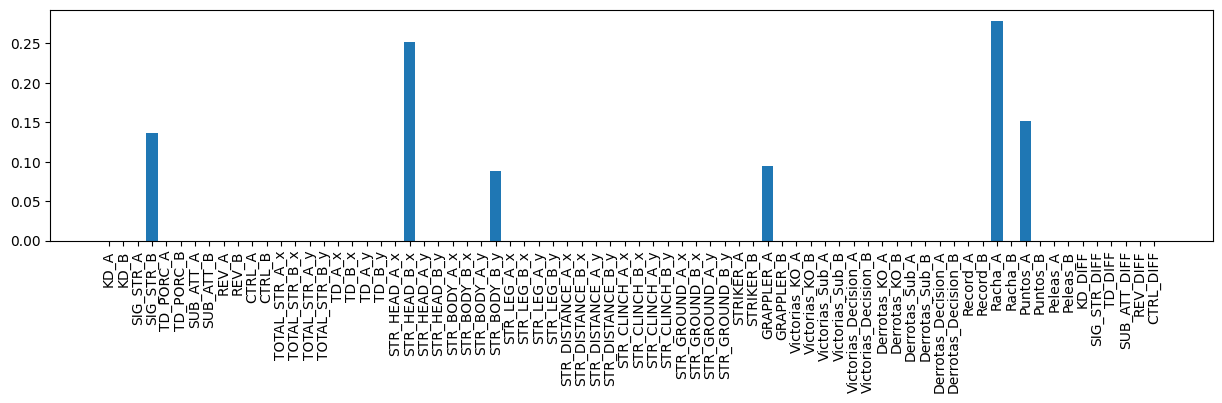

In [46]:
importance = tree2.feature_importances_
feature_names=X_train.columns
for i,v in enumerate(importance):
	if v > 0:
	    print('Variables con importancia en el modelo: %s, Importancia: %.5f' % (feature_names[i],v))

plt.figure(figsize=(15, 3))
plt.bar([x for x in range(len(importance))], importance, tick_label = feature_names)
plt.xticks(rotation = 90)
plt.show()

In [47]:
#Observamos todos los valores de las métricas.
print("-- Métricas del modelo con hiperparámetros ajustados --")
y_test_pred = tree2.predict(X_test)
y_test_prob = tree2.predict_proba(X_test)[:,1]
print("Accuracy:", accuracy_score(y_test, y_test_pred))
f1_test = f1_score(y_test, y_test_pred)
roc_auc_test = roc_auc_score(y_test, y_test_prob)
precision_test = precision_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)
log_loss_test = log_loss(y_test,y_test_prob)

print(f"F1-Score: {f1_test:.4f}")
print(f"AUC-ROC: {roc_auc_test:.4f}")
print(f"Precisión: {precision_test:.4f}")
print(f"Sensibilidad: {recall_test:.4f}")
print(f"Log-loss: {log_loss_test}")
print(confusion_matrix(y_test, y_test_pred))



-- Métricas del modelo con hiperparámetros ajustados --
Accuracy: 0.5841750841750841
F1-Score: 0.4523
AUC-ROC: 0.5852
Precisión: 0.5543
Sensibilidad: 0.3820
Log-loss: 0.6782888030644489
[[245  82]
 [165 102]]


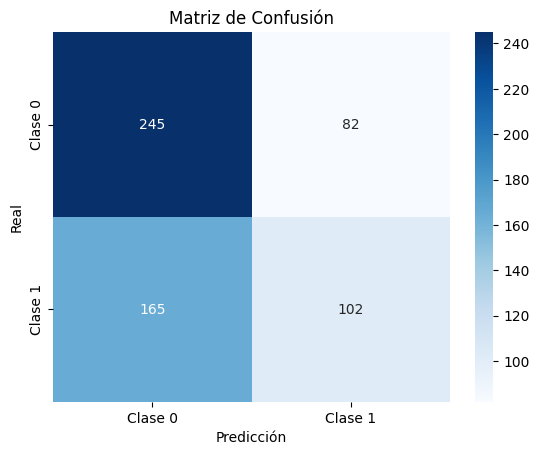

In [48]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_test_pred)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

El modelo con Random Search es idéntico al realizado con Grid Search anteriormente.